In [1]:
#импорты
import pandas as pd
import numpy as np

from datetime import datetime,timedelta, date
import requests
import io

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns 
import plotly as py
import plotly.graph_objs as go

from sklearn.neighbors import KernelDensity
from scipy.signal import argrelextrema

import warnings
warnings.filterwarnings("ignore")

### 0. Подготовка датасета

In [2]:
#загрузка данных
bond_url = 'https://iss.moex.com/iss/apps/infogrid/emission/rates.csv?iss.dp=comma&iss.df=%25d.%25m.%25Y&iss.tf=%25H:%25M:%25S&iss.dtf=%25d.%25m.%25Y%25H:%25M:%25S&iss.only=rates&limit=unlimited&lang=ru'
s=requests.get(bond_url).content
df = pd.read_csv(io.StringIO(s.decode('windows-1251')), sep=';', header=1)

### 1. Очистка данных

In [3]:
# 1. Выбор рублевых облигаций

#доступные валюты
print('Доступные валюты:', '\n', df['FACEUNIT'].value_counts(), '\n') #смотрим облигации в каких валютах у нас есть
df_2 = df[df['FACEUNIT'] == 'RUB'].reset_index(drop = True) #выбираем рублевые облигации

# 2. Выбор релевантных колонок

#доступные колокни
print('Доступные колонки:','\n', df.columns, '\n')

#переименовывание для удобства
df_2.rename(columns = {'SECID':'ID', 
                       'FACEVALUE':'NOMINAL_VALUE',
                       'INITIALFACEVALUE':'INITIAL_NOMINAL_VALUE',
                       'FACEUNIT':'NOMINAL_CURRENCY',
                       'COUPONDATE':'COUPONDATE_NEXT',
                       'INN':'EMITENT_INN',
                       'MATDATE':'REDEMPTIONDATE'}, inplace = True)

#выбор релевантных колонок
df_2 = df_2[['EMITENTNAME', 'NAME','INITIAL_NOMINAL_VALUE',
             'COUPONPERCENT','COUPONVALUE','COUPONFREQUENCY',
             'COUPONDATE_NEXT','COUPONDAYSPASSED','COUPONDAYSREMAIN',
             'COUPONLENGTH','PRICE_RUB','ISSUEDATE','REDEMPTIONDATE',
             'DAYSTOREDEMPTION','HIGH_RISK']]

# 3. Перевод в корректный формат данных

#типы данных до исправления
print('Типы данных до исправления:\n',df_2.dtypes, '\n')

#функция, исправляющая типы данных
def type_changer(x):
    if isinstance(x,str):
        x_new_type = float(x.replace(',','.'))
    else:
        x_new_type = x
    return x_new_type
    
#перевод строковых данных в числовые
for col in ['INITIAL_NOMINAL_VALUE', 'COUPONPERCENT', 'COUPONVALUE',
            'COUPONDAYSPASSED', 'COUPONDAYSREMAIN','COUPONLENGTH', 'PRICE_RUB']:
    df_2[col] = df_2[col].apply(type_changer)
    
#перевод строковых данных в datetime
for col in ['COUPONDATE_NEXT','ISSUEDATE', 'REDEMPTIONDATE']:
    df_2[col] = pd.to_datetime(df_2[col])

#типы данных после исправления
print('Типы данных после исправления:\n',df_2.dtypes, '\n')

# 4. Обработка пропусков

#кол-во строк до обработки пропусков
samples_before = df_2.shape[0]
print('Просмотр пропусков до обработки:\n',df_2.isnull().sum(), '\n')

#замена прпоусков у купона в относит.выражении
df_2['COUPONPERCENT'].replace(np.nan,0,inplace = True) # COUPONPERCENT - пропуск означает бескупонную облигацию

#замена прпоусков у купона в абсолбтном выражении
condition = (df_2['COUPONPERCENT'].notna()) & (df_2['COUPONVALUE'].isna()) & (df_2['COUPONFREQUENCY'].notna())
df_2['COUPONVALUE'].loc[condition] = ((df_2['COUPONPERCENT']*df_2['INITIAL_NOMINAL_VALUE'])/df_2['COUPONFREQUENCY'])/100 # COUPONVALUE - вычисляем по формуле

#удаление пропусков в прочих колонках
for col in ['COUPONFREQUENCY','COUPONDATE_NEXT','COUPONDAYSPASSED',
            'COUPONDAYSREMAIN','COUPONLENGTH','PRICE_RUB',
            'ISSUEDATE','REDEMPTIONDATE','DAYSTOREDEMPTION']:
    
    df_2 = df_2[df_2[col].isnull() == False].reset_index(drop = True)
    
#кол-во строк после обработки пропусков
print('Просмотр пропусков после обработки:\n',df_2.isnull().sum(), '\n')

# 5. Добавление нужных полей

#срок погашения облигации
df_2['DAYSTOREDEMPTION_SINCE_START'] = df_2['REDEMPTIONDATE'] - df_2['ISSUEDATE'] 
df_2['DAYSTOREDEMPTION_SINCE_START'] = df_2['DAYSTOREDEMPTION_SINCE_START'].apply(lambda x: x.days)

#сегодняшняя дата
df_2['TODAY'] = date.today() 
df_2['TODAY'] = pd.to_datetime(df_2['TODAY'])

#дата последней выплаты купона
df_2['COUPONDATE_LAST'] = df_2.apply(lambda x: x['TODAY'] - timedelta(days = x['COUPONDAYSPASSED']), axis = 1) 

# 6. Уберем ошибки в расчете даты выплаты купона

#удаление строк где неверно рассчитана дата следующей выплаты купона.
df_3 = df_2.copy()
df_3['is_mistake_in_coupon_date'] = df_3.apply(lambda x: 0 if x['COUPONDATE_NEXT'] - timedelta(days = x['COUPONDAYSREMAIN']) == x['TODAY'] else 1, axis = 1)
df_3 = df_3[df_3['is_mistake_in_coupon_date'] == 0].reset_index(drop = True)

#кол-во строк которое было удалено
samples_after = df_3.shape[0]
print('Удалено строк:', samples_before - samples_after, '\n')

# 7. Сформируем итогвоый датасет с удобным расположением колонок

df_3 = df_3[['EMITENTNAME','NAME','INITIAL_NOMINAL_VALUE','COUPONPERCENT','COUPONVALUE',
             'COUPONFREQUENCY','COUPONDATE_LAST','COUPONDAYSPASSED','TODAY','COUPONDAYSREMAIN',
             'COUPONDATE_NEXT','COUPONLENGTH','PRICE_RUB','ISSUEDATE','REDEMPTIONDATE',
             'DAYSTOREDEMPTION_SINCE_START','DAYSTOREDEMPTION','HIGH_RISK']]

Доступные валюты: 
 RUB    2363
USD     337
EUR      46
CHF       9
GBP       2
Name: FACEUNIT, dtype: int64 

Доступные колонки: 
 Index(['SECID', 'SHORTNAME', 'NAME', 'TYPENAME', 'ISIN', 'REGNUMBER',
       'LISTLEVEL', 'FACEVALUE', 'FACEUNIT', 'ISSUESIZE', 'IS_COLLATERAL',
       'IS_EXTERNAL', 'PRIMARY_BOARDID', 'PRIMARY_BOARD_TITLE', 'MATDATE',
       'IS_RII', 'DURATION', 'EVENINGSESSION', 'MORNINGSESSION',
       'IS_QUALIFIED_INVESTORS', 'HIGH_RISK', 'COUPONFREQUENCY', 'YIELDATWAP',
       'COUPONDATE', 'COUPONPERCENT', 'COUPONVALUE', 'COUPONDAYSPASSED',
       'COUPONDAYSREMAIN', 'COUPONLENGTH', 'ISSUEDATE', 'INITIALFACEVALUE',
       'SECSUBTYPE', 'STARTDATEMOEX', 'DAYSTOREDEMPTION', 'OFFERDATE',
       'EMITENTNAME', 'INN', 'LOTSIZE', 'PRICE', 'PRICE_RUB', 'RTL1', 'RTH1',
       'RTL2', 'RTH2', 'RTL3', 'RTH3', 'DISCOUNT1', 'LIMIT1', 'DISCOUNT2',
       'LIMIT2', 'DISCOUNT3', 'DISCOUNTL0', 'DISCOUNTH0'],
      dtype='object') 

Типы данных до исправления:
 EMITENTNAME        

### 2. Расчет полной купонной доходности к погашению

In [4]:
#accumulated coupon income(ACI)
df_3['ACI_period'] = df_3['COUPONDAYSPASSED']/df_3['COUPONLENGTH'] # доля периода выплаты купона (накопелнная)
#df_3 = df_3[df_3['ACI_period'] <= 0.2].reset_index(drop = True) # выбор значений <= 0.2
df_3['ACI'] = df_3['ACI_period'] * (((df_3['COUPONPERCENT']/100)/df_3['COUPONFREQUENCY']) * df_3['INITIAL_NOMINAL_VALUE'])

#future coupon income(FCI)
df_3['FCI_period'] = 365/df_3['COUPONLENGTH'] #период расчета 365 дней с текущей даты
df_3['FCI'] = df_3['FCI_period'] * (((df_3['COUPONPERCENT']/100)/df_3['COUPONFREQUENCY']) * df_3['INITIAL_NOMINAL_VALUE']) * 0.87

#tax
df_3['TAX'] = 0.87
df_3['TAX'].loc[df_3['INITIAL_NOMINAL_VALUE'] <= df_3['PRICE_RUB']] = 1

In [5]:
#входные параметры
N = df_3['INITIAL_NOMINAL_VALUE']
P = df_3['PRICE_RUB']
tax = df_3['TAX']
FCI = df_3['FCI']
ACI = df_3['ACI']

#комиссии брокера и биржи
broker_com = 0.06/100
exchange_com = 0.0125/100

#расчет полной купонной доходности
df_3['PROFIT'] = ((N-P)*tax + (FCI-ACI))/(1+broker_com+exchange_com)
df_3['COSTS'] = P+ACI
df_3['YIELD_FULL'] = (df_3['PROFIT']/df_3['COSTS']) * 100

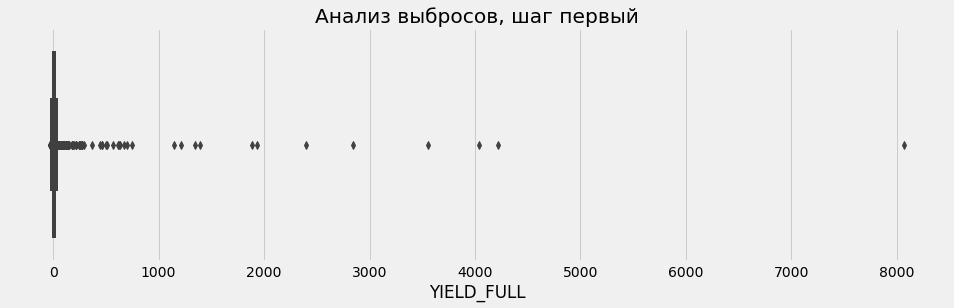

In [6]:
#boxplot полной купонной доходности к погашению
plt.style.use('fivethirtyeight')
plt.figure(figsize = (15,4))
sns.boxplot(df_3['YIELD_FULL'])
plt.title('Анализ выбросов, шаг первый')
plt.show()

#удалим выбросы с доходностью больше 100
df_4 = df_3[(df_3['YIELD_FULL'] <= 100)].reset_index(drop = True)

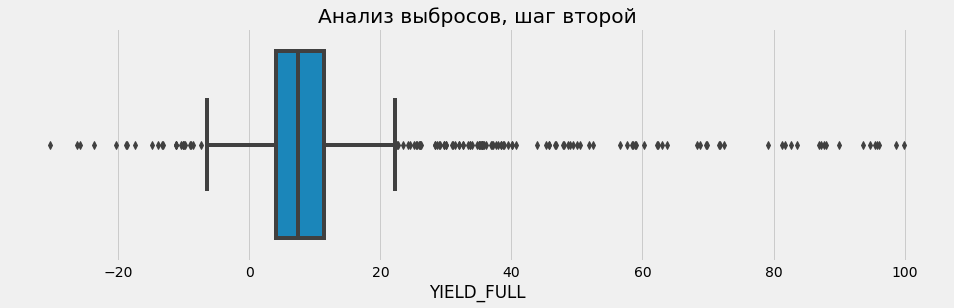

In [7]:
# boxplot полной купонной доходности к погашению после удаления выбросов
plt.figure(figsize = (15,4))
sns.boxplot(df_4['YIELD_FULL'])
plt.title("Анализ выбросов, шаг второй")
plt.show()

### 3. Рынок рублевых облигаций

In [8]:
# эмитенты, которые выпустили больше всех облигаций
df_4_emitents = df_4.groupby('EMITENTNAME').agg({'NAME':'count'}).reset_index().sort_values('NAME', ascending = False)

# средняя номинальная стоимость, купон, цена выкупа, срок погашения и полная доходность к погашению по рынку
df_4.describe().loc['mean'][['INITIAL_NOMINAL_VALUE',
                             'COUPONPERCENT',
                             'PRICE_RUB',
                             'DAYSTOREDEMPTION_SINCE_START',
                             'YIELD_FULL']]

INITIAL_NOMINAL_VALUE           64482.817869
COUPONPERCENT                       7.133497
PRICE_RUB                       60941.229991
DAYSTOREDEMPTION_SINCE_START     2736.198454
YIELD_FULL                         10.625705
Name: mean, dtype: float64

#### 3.1 Распредления

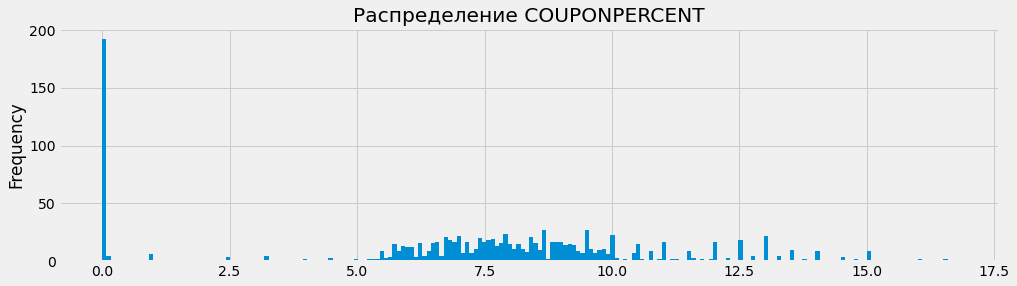

In [9]:
#распределение COUPONPERCENT
plt.style.use('fivethirtyeight')
df_4['COUPONPERCENT'].plot(kind = 'hist',
                           figsize = (15,4),
                           bins = 200,
                           title = 'Распределение COUPONPERCENT',
                           xlabel = 'COUPONPERCENT')
plt.show()

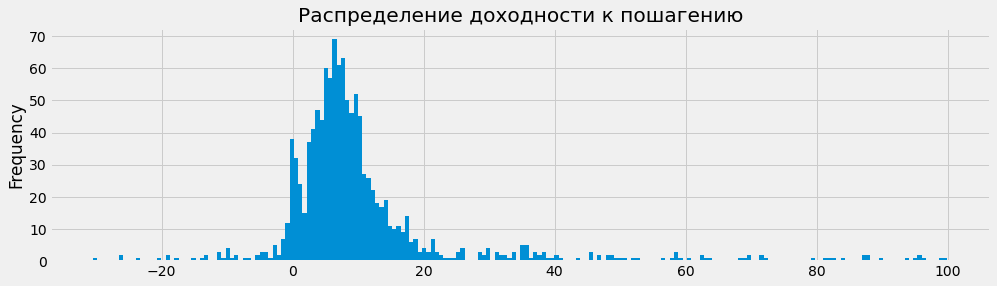

In [10]:
#распределение полной купонной доходности к погашению (гистограмма)
df_4['YIELD_FULL'].plot(kind = 'hist',
                   figsize = (15,4),
                   bins = 200,
                   title = 'Распределение доходности к пошагению',
                   xlabel = 'YIELD_FULL')
plt.show()

### 3. Кластеризация купонной доходности

In [11]:
#параметры купонной доходности
X = df_4['YIELD_FULL'].values.reshape(-1, 1)

#### 3.1 Распределение купонной доходности (плотность)

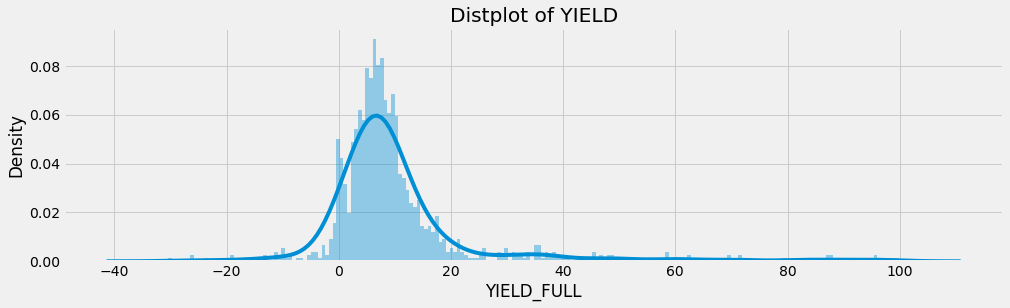

In [12]:
#параметры графика
plt.figure(figsize = (15,4))
true_dens = sns.distplot(df_4['YIELD_FULL'],bins = 200)
plt.title(f'Distplot of YIELD')
plt.show()

#### 3.2 Возможные ядерные оценки (K)

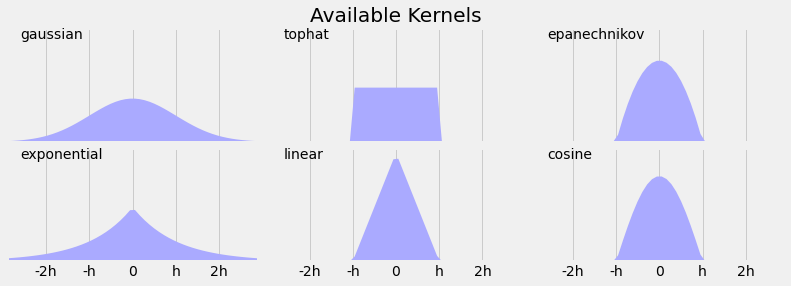

In [13]:
#входные параметры
X_plot = np.linspace(np.min(X), np.max(X), len(X)).reshape(-1,1)
X_src = np.zeros((1, 1))
kernels = ["gaussian", "tophat", "epanechnikov", "exponential", "linear", "cosine"]

#параметры гарфика
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)
fig.subplots_adjust(left=0.05, right=0.95, hspace=0.05, wspace=0.05)

def format_func(x, loc):
    if x == 0:
        return "0"
    elif x == 1:
        return "h"
    elif x == -1:
        return "-h"
    else:
        return "%ih" % x

#отрисовка плотностей возможных ядерных оценок
for i, kernel in enumerate(kernels):
    
    axi = ax.ravel()[i]
    kde = KernelDensity(kernel=kernel).fit(X_src)
    log_dens = kde.score_samples(X_plot)
    
    axi.fill(X_plot, np.exp(log_dens), "-k", fc="#AAAAFF")
    axi.text(-2.6, 0.95, kernel)

    axi.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    axi.xaxis.set_major_locator(plt.MultipleLocator(1))
    axi.yaxis.set_major_locator(plt.NullLocator())

    axi.set_ylim(0, 1.05)
    axi.set_xlim(-2.9, 2.9)

fig.set_size_inches([12,4])
ax[0, 1].set_title("Available Kernels")
plt.show()

#### 3.3 Ядерный оценщик YIELD_FULL (1/nh * sum(K((x-x_i/h))))

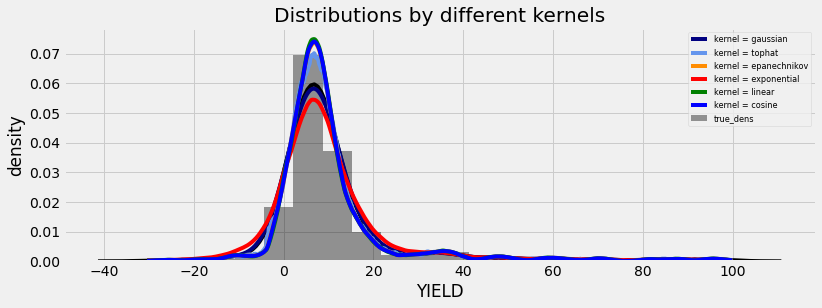

In [14]:
#входные параметры
X_plot = np.linspace(np.min(X), np.max(X), len(X)).reshape(-1,1)
h = 1.06 * X.std() * (len(X)**(-1/5)) #ширина полосы

colors = ["navy", "cornflowerblue", "darkorange",'red','green','blue']
kernels = ["gaussian", "tophat", "epanechnikov", "exponential", "linear", "cosine"]

# отрисовка наблюдаемой плотности
fig, ax = plt.subplots()
sns.distplot(X, bins = 20, norm_hist = True, color = 'black', label = 'true_dens' )

# отрисовка плотности каждого ядерного оценщика
for color, kernel in zip(colors, kernels):
    
    kde = KernelDensity(kernel=kernel, bandwidth=h).fit(X)
    log_dens = kde.score_samples(X_plot)
    
    ax.plot(X_plot,np.exp(log_dens),color=color,linestyle="-",label=f'kernel = {kernel}')
    
fig.set_size_inches([12,4])
ax.set_xlabel('YIELD')
ax.set_ylabel('density')
ax.set_title('Distributions by different kernels')
ax.legend(loc='best', fontsize = 'xx-small')

plt.show()

In [15]:
# Вывод: Судя по графику, tophat лучше всего оценивает распределение

#### 3.4 Кластеризация при помощи разных kernels. выбор наилучшего.

Grouping kernel gaussian:
[[29.19633177]
 [55.20065427]
 [76.94564807]
 [91.51703568]]
Grouping kernel tophat:
[[-6.55961165]
 [-5.88708607]
 [ 3.97662246]
 [ 4.42497285]
 [ 6.44254959]
 [ 7.45133797]
 [ 8.34803874]
 [12.15901704]
 [15.07329456]
 [18.77218526]
 [21.57437518]
 [22.13481317]
 [25.83370387]
 [27.40293022]
 [29.42050697]
 [32.22269689]
 [33.00731007]
 [33.67983565]
 [34.01609844]
 [35.02488682]
 [41.86223023]
 [42.8710186 ]
 [52.62263954]
 [90.84451009]]
Grouping kernel epanechnikov:
[[-30.3221822 ]
 [-24.15736437]
 [-22.58813801]
 [-17.76837135]
 [-17.20793336]
 [-15.07826902]
 [ -8.80136359]
 [ -7.23213723]
 [ 25.83370387]
 [ 28.0754558 ]
 [ 28.74798139]
 [ 29.42050697]
 [ 29.75676976]
 [ 42.758931  ]
 [ 47.91496046]
 [ 54.41604109]
 [ 59.79624574]
 [ 66.07315117]
 [ 75.71268451]
 [ 76.27312249]
 [ 83.11046591]
 [ 83.3346411 ]
 [ 85.24013025]
 [ 85.68848064]
 [ 86.13683102]
 [ 87.48188219]
 [ 91.51703568]
 [ 96.00053955]]
Grouping kernel exponential:
[[-25.72659073]
 [ 3

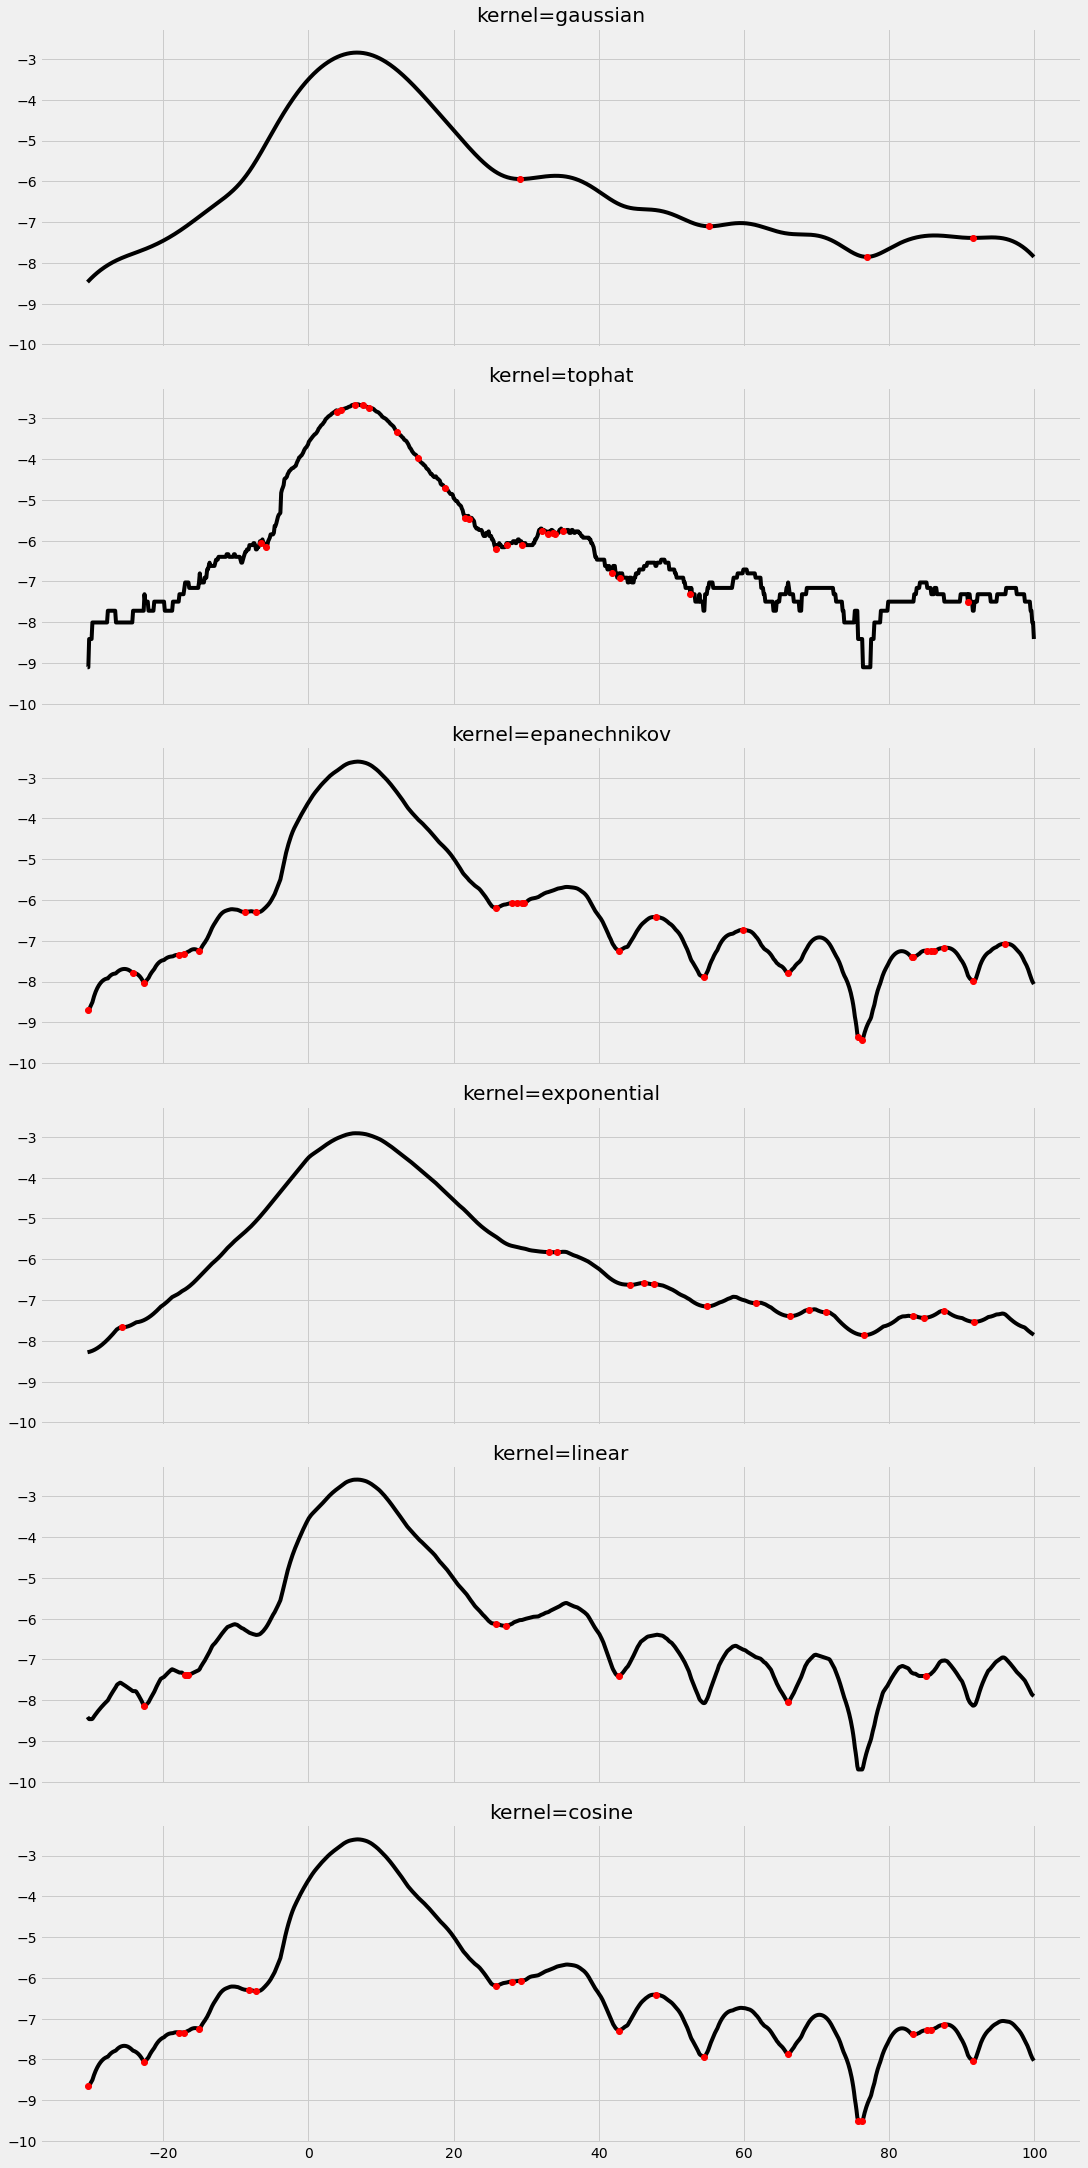

In [16]:
#общие параметры графика
rows = len(kernels)
cols = 1
axs = plt.figure(figsize=(15,30),
                 constrained_layout=True).subplots(rows,cols,sharex=True,sharey=True)

#отрисовка кластеризации при помощи каждого kernel
for ax, kernel in zip(axs,kernels):
    
    kde = KernelDensity(kernel=kernel, bandwidth=h).fit(X)
    log_dens = kde.score_samples(X_plot)
    min_, max_ = argrelextrema(log_dens, np.less)[0], argrelextrema(log_dens, np.greater)[0]
    
    print(f'Grouping kernel {kernel}:')
    
    if len(min_) > 1:
        print(X_plot[min_])
        ax.set_title('kernel=%s' % str(kernel))
        ax.plot(X_plot, log_dens, 'black', X_plot[min_], log_dens[min_], 'ro')
        
    else:
        print('error')

#### 3.5 Кластеризация при помощи лучшего kernel

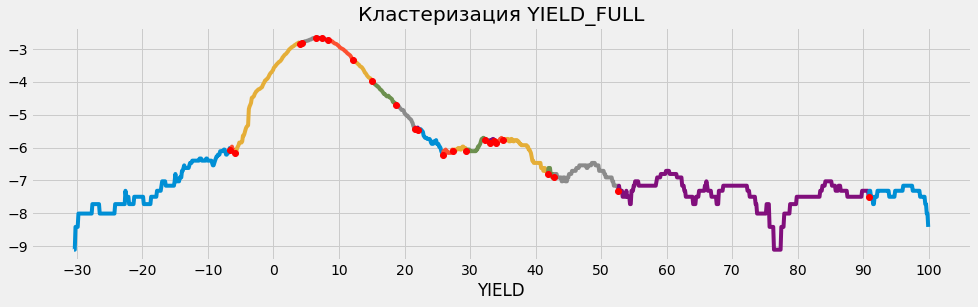

Границы кластеров:
 [-6.56, -5.89, 3.98, 4.42, 6.44, 7.45, 8.35, 12.16, 15.07, 18.77, 21.57, 22.13, 25.83, 27.4, 29.42, 32.22, 33.01, 33.68, 34.02, 35.02, 41.86, 42.87, 52.62, 90.84]


In [17]:
#расчет границ интервалов кластеризации
kde = KernelDensity(kernel='tophat', bandwidth=h).fit(X)
log_dens = kde.score_samples(X_plot) #для удобства задания параметров гарфика
min_, max_ = argrelextrema(log_dens, np.less)[0], argrelextrema(log_dens, np.greater)[0]

#отрисовка гарфика, визуализирующего кластеризацию
fig, ax = plt.subplots()

ax.plot(X_plot[:min_[0]+1], log_dens[:min_[0]+1])
for i in range(len(min_)-1):
    ax.plot(X_plot[min_[i]:min_[i+1]+1], log_dens[min_[i]:min_[i+1]+1])

ax.plot(X_plot[min_[len(min_)-1]:], log_dens[min_[len(min_)-1]:])
ax.plot(X_plot[min_], log_dens[min_], 'ro')

fig.set_size_inches([15,4])
ax.set_xlabel('YIELD')
ax.set_title('Кластеризация YIELD_FULL')
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

plt.show()

#вывод границ
intervals = [round(i,2) for i in X_plot[min_].reshape(1,-1)[0]]
print('Границы кластеров:\n',intervals)